# Start of analysis
## import reqs

In [1]:
import pandas as pd 

import os

In [2]:
import glob
import pandas as pd
from concurrent.futures import ThreadPoolExecutor

# Find all Parquet files starting with "datacenter"
#file_paths = glob.glob("datacenter*.parquet")
files = [f for f in os.listdir("/workspaces/visualization-energy/data/processed_data") if f.startswith("datacenter")]
print(files)
# Function to read a Parquet file and return a DataFrame
def read_parquet(file_path):
    return pd.read_parquet(file_path)

# Read Parquet files in parallel using ThreadPoolExecutor
with ThreadPoolExecutor() as executor:
    # Submit tasks to read Parquet files
    futures = [executor.submit(read_parquet, os.path.join("/workspaces/visualization-energy/data/processed_data", file_path)) for file_path in files]

    # Wait for all tasks to complete and get the results
    dfs = [future.result() for future in futures]

# Join the DataFrames into one dataset
df = pd.concat(dfs)

# Print the joined dataset
print(df)


['datacenter_1_68_.parquet', 'datacenter_0_9_.parquet', 'datacenter_0_22_.parquet', 'datacenter_1_71_.parquet', 'datacenter_1_53_.parquet', 'datacenter_1_55_.parquet', 'datacenter_1_52_.parquet', 'datacenter_1_50_.parquet', 'datacenter_1_16_.parquet', 'datacenter_1_2_.parquet', 'datacenter_1_13_.parquet', 'datacenter_1_24_.parquet', 'datacenter_1_69_.parquet', 'datacenter_1_10_.parquet', 'datacenter_0_3_.parquet', 'datacenter_0_23_.parquet', 'datacenter_1_32_.parquet', 'datacenter_0_14_.parquet', 'datacenter_1_34_.parquet', 'datacenter_1_4_.parquet', 'datacenter_1_19_.parquet', 'datacenter_1_38_.parquet', 'datacenter_0_28_.parquet', 'datacenter_1_28_.parquet', 'datacenter_1_23_.parquet', 'datacenter_1_35_.parquet', 'datacenter_0_2_.parquet', 'datacenter_0_8_.parquet', 'datacenter_1_48_.parquet', 'datacenter_1_17_.parquet', 'datacenter_1_61_.parquet', 'datacenter_1_45_.parquet', 'datacenter_1_0_.parquet', 'datacenter_0_30_.parquet', 'datacenter_1_31_.parquet', 'datacenter_0_16_.parquet'

In [3]:
df.fecha_servidor = pd.to_datetime(df.fecha_servidor)

In [4]:
df.fecha_esp32 = pd.to_datetime(df.fecha_esp32)

In [21]:
df.columns

Index(['MAC', 'weekday', 'fecha_servidor', 'fecha_esp32', 'voltaje',
       'corriente', 'potencia', 'frecuencia', 'energia', 'fp', 'ESP32_temp',
       'WORKSTATION_CPU', 'WORKSTATION_CPU_POWER', 'WORKSTATION_CPU_TEMP',
       'WORKSTATION_GPU', 'WORKSTATION_GPU_POWER', 'WORKSTATION_GPU_TEMP',
       'WORKSTATION_RAM', 'WORKSTATION_RAM_POWER'],
      dtype='object')

In [10]:
df.dtypes

MAC                              object
weekday                           int64
fecha_servidor           datetime64[ns]
fecha_esp32              datetime64[ns]
voltaje                         float64
corriente                       float64
potencia                        float64
frecuencia                      float64
energia                         float64
fp                              float64
ESP32_temp                      float64
WORKSTATION_CPU                 float64
WORKSTATION_CPU_POWER           float64
WORKSTATION_CPU_TEMP              int64
WORKSTATION_GPU                 float64
WORKSTATION_GPU_POWER             int64
WORKSTATION_GPU_TEMP            float64
WORKSTATION_RAM                 float64
WORKSTATION_RAM_POWER           float64
dtype: object

I am happy with the dtypes, saving to file.

In [ ]:
df.to_parquet("/workspaces/visualization-energy/data/datacenter_processed.parquet")

<Axes: xlabel='fecha_servidor'>

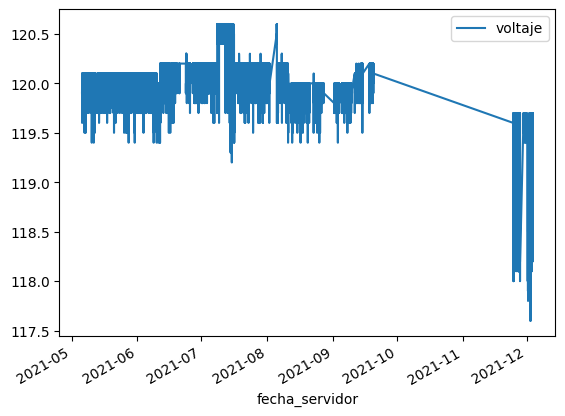

In [22]:
df.groupby("fecha_servidor").agg({"voltaje": "mean"}).plot()

<Axes: xlabel='fecha_servidor'>

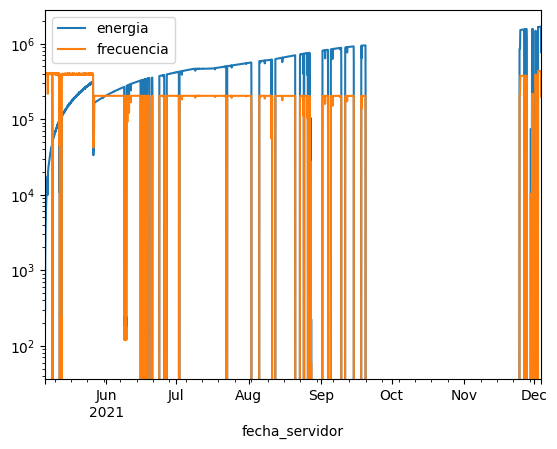

In [9]:
df.groupby([pd.Grouper(key='fecha_servidor', freq='h')]).agg({"energia": "sum", "frecuencia": "sum"}).plot(logy=True)

# EDA Plan: Visualizing Energy Consumption Data of a Datacenter

## Introduction
Provide a brief introduction to the project and the purpose of the EDA.

## Data Description
Describe the energy consumption data of the datacenter, including the variables/columns available and their meanings.

## Data Cleaning and Preprocessing
Outline the steps taken to clean and preprocess the data, such as handling missing values, removing duplicates, and transforming variables if necessary.

## Exploratory Data Analysis
Perform exploratory data analysis to gain insights into the energy consumption data. Include the following visualizations:

### 1. Time Series Analysis
- Plot the energy consumption over time to identify any trends or patterns.
- Analyze the data for seasonality, cyclic patterns, or any other temporal characteristics.

### 2. Distribution Analysis
- Visualize the distribution of energy consumption values.
- Identify any outliers or anomalies in the data.

### 3. Correlation Analysis
- Explore the relationships between different variables.
- Calculate correlation coefficients and create correlation matrices.
- Visualize the correlations using heatmaps or scatter plots.

### 4. Aggregated Analysis
- Aggregate the energy consumption data by different dimensions, such as day of the week, hour of the day, or specific devices.
- Visualize the aggregated data to identify any patterns or trends.

### 5. Comparison Analysis
- Compare the energy consumption of different devices or areas within the datacenter.
- Use bar charts, box plots, or other appropriate visualizations to highlight the differences.

## Conclusion
Summarize the key findings from the EDA and any insights gained from the visualizations.

## Next Steps
Outline the next steps in the analysis, such as feature engineering, modeling, or further data exploration.
